# Road traffic death rates in Brazil and in the world

In this notebook, we will explore the global trends of road death, according to the WHO data, and the Brazilian trends, using data from the Brazilian Ministry of Health.

The goal is to see how Brazil compares to most other countries and potentially indetify what are the main drivers of change.

#### Importing packages and defining settings

In [1]:
from functools import reduce
import geobr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysus
import seaborn as sns
from sklearn.linear_model import LinearRegression

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#### Helper functions related to this notebook

In [3]:
def format_who_data(path):
    '''
    Formats the WHO dataset, keeping only the desired columns.
    
    Returns two dataframes: one showing all the time interval
    available data and one showing only the results for the 
    latest year.
    
    Arguments:
    > path: string. the path to the WHO data file.
    
    Returns:
    > a dictionary containing two formated dataframe.
    the key 'all' is used to store a dataframe with all
    the dates in the time inteval.
    the key 'latest' shows only the latest entries in the dataframe,
    which in this case is the year 2019.
    '''
    
    # Reads the CSV in thee specified path
    df = pd.read_csv("../data/WHO/WHO-data-estimated-road-traffic-death-rates.csv")

    # Keeps only the desired columns
    df = df[['SpatialDimValueCode', 'Location', 'Value', 
             'FactValueNumeric', 'FactValueNumericLow', 'FactValueNumericHigh',
             'Period', 'IsLatestYear']]
    
    # Renames column
    df = df.rename(columns={"SpatialDimValueCode":"LocationId",
                           "FactValueNumeric": "DeathRatio100k",
                           "FactValueNumericLow": "DeathRatio100kLowerBound",
                           "FactValueNumericHigh": "DeathRatio100kHigheBound"})
    
    # Keep only most recent year – 2019
    df_latest = df[df.IsLatestYear]
    
    # On the most recent year, ranks countires by the center
    # of the estimate to see the countries with the highest rates
    df_latest['ranking'] = df_latest['DeathRatio100k'].rank(method='min', ascending=False)

    
    return {
        "all": df, 
        "latest": df_latest
    }    

In [4]:
def format_datasus_death_data(path, level):
    '''
    Reads and formats total mortality data exported
    from the Ministry of Health's  Datasus portal. 
    
    Returns it as a formatted dataframe,
    with the colums renamed to English. This assumes
    that the CSV files were cleaned beforehand, removing
    the useless leading rows in the header and footer.
    
    Arguments:
    > path: string. the path to the downloaded file.
    > level: can be 'brazil', 'region', 'state', 'micro' or 'muni'.
    The only formatting difference is that 'brazil' level data is long format,
    while the others are wide. Option 'region' refers to the five regions level,
    'states' refers to the 27 units of the Federation, 'micro' to the microrregions 
    and 'muni' to the cities.
    '''
    
    # Reads the file, accounting for the metadata
    # that is on the top and bottom rows.
    df = pd.read_csv(path, encoding='Latin5', 
                      sep=';', na_values=['-'])
    
    # 'brazil'level is treated different, as the data comes in long format.
    if level=='brazil':
    
        # Renames it for readability
        df = df.rename(columns={
            "Ano do Óbito": "Year",
            "Óbitos_p/Ocorrênc": "TotalDeaths",
        })
        
        # Drop all columns where Year is 'Total'
        df = df[df.Year!='Total'].reset_index(drop=True)

        # Assign a location id
        df['Location'] = 'Brazil'
        df['LocationId'] = '0'
    
    # All the others go through the same processing
    else:
        
        # Removes the Total column, which is a sum of all the selected entities.
        df = df.drop(columns='Total')
        
        # Renaming the first column to standardize it with the WHO data.
        df = df.rename(columns={
            df.columns[0]: 'Location'
        })
        
        # The first column will always contain the location id + location name.
        # If we extract the digits using regex, we will end up with unique location ids
        # for the state, city or region. 
        # We will do so and create separate columns for name and id.
        df['LocationId'] = df['Location'].str.extract("(\d+)\s\w+")
        df['Location'] = df['Location'].str.replace("(\d+)", '', regex=True).str.strip()
        
        # We want the data to be in long format as well, instead of having a column for each year.
        df = pd.melt(df, id_vars=['Location', 'LocationId'], var_name='Year', value_name='TotalDeaths')
                

    # Removes years with no associated data
    df = df.dropna(subset=['TotalDeaths']).reset_index(drop=True)
        
    return df

In [5]:
def predict_population_by_place(df, target_year):
    '''
    Predicts the population for each Location for a given year using a linear regression.
    The function assumes a linear population growth. 
    
    We are doing that to estimate 2022 values, since the 2022 census results showed a 
    smaller population than in the previous projections, and, to date, there is no retroprojection 
    of the population that uses the 2022 census a reference. If we used the 2010-2021 projections
    alognside the results of the 2022 census, the death ratios would artificially drop.
    
    Therefore, we decided to use a projection based in 2010-2021 because this 
    is what was used to report reesults in the previous years.
    
    The DataFrame should have three columns: 'Year', 'Population', and 'Location'.

    Arguments:
    > df: pandas DataFrame with columns 'year', 'value', and 'Location'
    > target_year: int. The year for which the prediction is to be made

    Disclaimer: This function was written with the help of ChatGPT.
    '''

    # This subfunction is applied within each group of a groupby.
    def regress_and_predict(group):

        # Accessing the values for the year columns and turining it into a numpy vector
        years = group['Year'].values.reshape(-1, 1)

        # Doing the same for population levels
        population = group['Population'].values.reshape(-1, 1)

        # Creates the Linear Regression model
        model = LinearRegression()

        # Fits the model with the 2011-2021 population data
        model.fit(years, population)

        # Performs the prediction. 
        # We need to pass the target year as a numpy array, but 
        # since we are passing a single year, we select it using index slicing
        # for easier processing.
        return model.predict(np.array([[target_year]]))[0, 0]

    # Applies the linear regression to each group
    predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()

    # Makes it a dataframe and renames the result column to Population
    predictions = predictions.reset_index(name='Population')

    # Adds the target year information
    predictions['Year'] = str(target_year)


    return predictions

In [6]:
def format_datasus_population_data(path, level):
    '''
    Reads and formats the downloaded population data.
    
    Returns it as a formatted dataframe, with the colums renamed to English.
    
    This assumes that the CSV files were cleaned beforehand, removing
    the useless leading rows in the header and footer.
    
    
    Arguments:
    > path: string. the path to the downloaded file.
    > level: can be 'brazil', 'region', 'state', 'micro' or 'muni'.
    The only significant differenece is that 'brazil' level data is long format,
    while the others are wide.
    '''
    
    # Reads the file, accounting for the metadata
    # that is on the top and bottom rows.
    df = pd.read_csv(path, encoding='Latin5', 
                      sep=';', na_values=['-'])
    
  
    # Brazil level data already comes in long format
    if level == 'brazil':

        df = df.rename(columns={
            "Ano": "Year",
            "População_residente": "Population",
        })
        
        df['Location'] = 'Brazil'
        df['LocationId'] = '0' # Sets an arbitrary id

    
    # All the other come in wide format
    else:
        
        # Renaming the first column
        df = df.rename(columns={
            df.columns[0]: 'Location'
        })
    
        # Extracts the id and separates it from the name in different columns
        df['LocationId'] = df['Location'].str.extract("(\d+)\s\w+")
        df['Location'] = df['Location'].str.replace("(\d+)", '', regex=True).str.strip()

        # From wide to long
        df = pd.melt(df, id_vars=['Location', 'LocationId'], var_name='Year', value_name='Population')
        
        # Remove rows with 'TOTAL' on it
        df = df.dropna(subset='LocationId').reset_index(drop=True)

    # Performs the linear regression to compute 2022 population
    new_data = predict_population_by_place(df, 2022)
    
    # Returns the concatenated dataframes
    return pd.concat([df, new_data], ignore_index=True)
    


In [7]:
def prepare_death_rate_df(path_deaths, path_pop, level):
    '''
    Creates a dataframe based on Datasus data,
    joining together the death counts for a year,
    the population estimates for the same year and
    then computing a death ratio.
    
    Arguments:
    
    > path_deaths: str. path to the dataframe containing the death totals.
    > path_pop: str. path to the dataframe containing the population counts.
    > deaths_kind and pop_kind: string. could be 'long' or 'wide'. describe how the
    data is structured. wide format has the information for each year in separate columns.
    long format only has a single 'year' column with the relevant information stored in it.
    '''
    
    # Read and format the death data
    df_deaths = format_datasus_death_data(path_deaths, level)
    
    # Read and format the population data
    df_pop = format_datasus_population_data(path_pop, level)
    
    # Assures that all years are in string type
    df_pop['Year'] = df_pop['Year'].astype(str)
    df_deaths['Year'] = df_deaths['Year'].astype(str)

    # Join then together
    df = df_deaths.merge(df_pop, on=['Location', 'LocationId', 'Year'])
    
    # Compute the death ratios for each 100,000 people
    df['DeathRatio100k'] = df['TotalDeaths'] / df['Population'] * 100000
    
    # Return the data
    return df


In [8]:
def format_wb_data(path):
    '''
    Reads and formats the data downloaded from the World Bank.
    Returns the formatted dataframe.
    
    Arguments:
    > path: string. the path to the downloaded file.
    '''
    
    df = pd.read_excel(path, sheet_name=0)
    df = df[['Economy', 'Code', 'Region', 'Income group']]
    df = df.rename(columns={
                       "Code": "LocationId",
                       "Income group": "IncomeGroup",
                       "Region": "WorldBankRegion",
    })
    
    return df

In [9]:
def create_stripplot(df, 
                    palette, 
                    region_order, 
                    income_group_order, 
                    title, 
                    xlabel, ylabel,
                    region_col, 
                    income_group_col,
                    region=None,
                    income_group=None,
                    LocationId=None,
                    fname=None,
):
    '''
    Creates a custom strip plot comparing different regions and income groups, 
    with emphasis on a specific country.
    
    Argments:

    > df: Pandas DataFrame containing the data.
    > region_col: Name of the column in df that represents regions.
    > income_group_col: Name of the column in df that represents income groups.
    > palette: Dictionary defining the color palette for income groups.
    > region_order: List of regions in the desired order for the plot.
    > income_group_order: List of income groups in the desired order for the plot.
    > LocationId: The id code for the places to be highlighted.
    > title: Title of the plot.
    > xlabel: Label for the x-axis.
    > ylabel: Label for the y-axis.
    > fname: defaults to None. If it's a string, then the dataframe will be processed
    and saved in the format requires by DataWrapper using the fname in the output directory.

    Disclaimer: This function was adapted with the help of ChatGPT.
    '''    
    # Gets only the latest year
    df_sorted = df[df.IsLatestYear].copy()
    
    # Sorts by region and income group, using the order determined in the arguments
    df_sorted[region_col] = pd.Categorical(df_sorted[region_col], categories=region_order, ordered=True)
    df_sorted[income_group_col] = pd.Categorical(df_sorted[income_group_col], categories=income_group_order, ordered=True)
    df_sorted = df_sorted.sort_values([region_col, income_group_col])
    
    # Plotting the first stripplot
    plt.figure(figsize=(6, 4))
    sns.stripplot(data=df_sorted, hue=income_group_col, x='DeathRatio100k', 
                  y=region_col, jitter=True, palette=palette, size=4, alpha=.4)
    
    # Checks how many locations should be highlighted
    if LocationId:
        if isinstance(LocationId, list):
            pass # If it's a list, plot all countries
        elif isinstance(LocationId, str):
            LocationId = [LocationId] # If it's a string, turns into a single-element list
        else:
            raise ValueError


        # Highlighting specific places
        
        # Creates a subset of highlights to plot on top of other countries
        to_highlight = df_sorted[df_sorted['LocationId'].isin(LocationId)]
        
        # If the highlighted countries include Brazil, we will use the 2022 national data instead
        if 'BRA' in LocationId:
            df.loc[df.LocationId=='BRA']['DeathRatio100k'] = 15.67 # 2022 data according to Datasus
        
        # Plots the stripplot with the highlights
        sns.stripplot(data=to_highlight, x='DeathRatio100k', 
                      y=region_col, hue=income_group_col, palette=palette, 
                      edgecolor='black', linewidth=1, size=6, legend=False)
        
        # Adds informative text labels
        for _, row in to_highlight.iterrows():
            plt.text(row['DeathRatio100k'], row[region_col], row['Location'], 
                     ha='center', va='bottom', fontweight='bold',
                     color='black')

    # Calculates and add lines for regional averages
    if region:
        avg = df_sorted[df_sorted[region_col] == region]['DeathRatio100k'].median()
        plt.axvline(x=avg, color='#7f8891', linestyle='--', label=f'Median: {region}')

    if income_group:
        avg = df_sorted[df_sorted[income_group_col] == income_group]['DeathRatio100k'].median()
        plt.axvline(x=avg, color='#7f8891', linestyle='-', label=f'Median: {income_group}')

    # Styles
    plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()
    
    # If there is a file name on the arguments, we will process the data
    # and export is a CSV for usage in Datawrapper.
    if fname:
        
        # Processes data so it's on the hacky datawrapper stripplot/swarmplot format
        
        if 'geometry' in df_sorted.columns:
            # If there's geo data, get rid of it
            df_sorted = df_sorted.drop(columns=['geometry'])

        # Use factorize to assign codes for each category starting from 0
        codes, unique = pd.factorize(df_sorted[region_col])

        # Assing the codes to the relevant regions
        df_sorted['y_order'] = codes * 2

        # Now randomly position the dots over the x axis, from (code + 0.4) to (code + 0.6)
        df_sorted['y_position'] = df_sorted['y_order'].apply(lambda x: np.random.uniform(x + 0.2, x + 0.8))

        df_sorted.to_csv(f"../output/{fname}", index=False)

In [10]:
def classify_states_by_gdp(row):
    '''
    TO DO: classify the Brazilian states
    into different World Bank income groups,
    according to their latest reported GDP
    per capita.
    '''
    raise NotImplementedError

In [11]:
def join_with_states(who_df, states_df):
    '''
    Returns a dataframe that treats the Brazilian states as individual countries
    for comparison with the WHO dataframe.
    
    Arguments:
    
    > who_df: pandas DataFrame. the dataframe with the original who data.
    > states_df: pandas DataFrame. the dataframe with the formatted states data.
    '''

    # Add the necessary information that is currently missing from states_df
    states_df['IsLatestYear'] = states_df.Year=='2022'
    states_df['IncomeGroup'] = ''
    states_df['WorldBankRegion'] = 'Brazilian states'
    
    who_df['WorldBankRegion'] = 'Countries'
    
    
    # Join them back with the who_df
    return pd.concat([states_df, who_df], ignore_index=True)
    

In [12]:
def read_geobr(data, kind):
    '''
    Uses the geobr package to read the outline of the desired Brazilian
    regions. Join them with the relevant data.
    
    Arguments:
    > data. the pandas dataframe for which the outline should be added.
    > kind. a string denoting the desired region. can be 'state', 'region', 'micro' or 'muni'.
    '''
    
    if kind == 'region':
        outline = geobr.read_region(year=2020)
        outline['code_region'] = outline.code_region.astype(int).astype(str)
        outline = outline.rename(columns={
            "code_region": "RegionId",
            "name_region": "RegionName",
        })
    
        data = outline.merge(data, left_on='RegionId', right_on='LocationId')
    
    elif kind == 'state':
        outline = geobr.read_state('all')
        outline['code_region'] = outline.code_region.astype(int).astype(str)
        outline['code_state'] = outline.code_state.astype(int).astype(str)
        outline = outline.rename(columns={
            "code_region": "RegionId",
            "name_region": "RegionName",
            "code_state": "StateId",
            "abbrev_state": "StateAbbrev",
            "name_state": "StateName"
        })
                
        data = outline.merge(data, left_on='StateId', right_on='LocationId')
        
    elif kind == 'micro':
        outline = geobr.read_micro_region('all')
        outline['code_state'] = outline.code_state.astype(int).astype(str)
        outline['code_micro'] = outline.code_micro.astype(int).astype(str)
        outline = outline.rename(columns={
            "code_state": "StateId",
            "abbrev_state": "StateAbbrev",
            "name_state": "StateName",
            "code_micro": "MicroId",
            "name_micro": "MicroName",
        })
        
        data = outline.merge(data, left_on='MicroId', right_on='LocationId')

        
    elif kind == 'muni':
        outline = geobr.read_municipality('all')
        display
        outline['code_state'] = outline.code_state.astype(int).astype(str)
        outline['code_muni'] = outline.code_muni.astype(int).astype(str)
        outline = outline.rename(columns={
            "code_state": "StateId",
            "abbrev_state": "StateAbbrev",
            "name_state": "StateName",
            "code_muni": "MuniId",
            "name_muni": "MuniName",
        })     
        
        data = outline.merge(data, left_on='MuniId', right_on='LocationId')

        
    else:
        raise ValueError("Kind can be one of the following: ['state', 'region', 'micro', 'muni']")

        
    return data

In [13]:
def plot_region_time_evolution(df, region_col, year_col, value_col, start_year, end_year):
    """
    Plots a small multiple of line charts showing the time evolution of reported values.
    Each chart represents a region.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    region_col (str): Column name representing the regions.
    year_col (str): Column name representing the years.
    value_col (str): Column name representing the reported values.
    start_year (str): Year in which the plotting interval will start.
    end_year (str): Year in which the plotting interval will end.
    
    Disclaimer: function written with the help of ChatGPT.
    """
    
    # Get unique regions
    regions = df[region_col].unique()

    # Number of plots (one for each region)
    n_plots = len(regions)
    n_cols = 3  # Number of columns in the subplot grid
    n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate how many are rows needed, 
                                               # removing extra empty grids

    # Create a subplot for each region, proportional to the number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
    sns.despine()
    
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, region in enumerate(regions):
        
        ax = axes[i]
        
        # Filter data for the current region and plot is time evolution
        subset = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
        subset = subset[subset[region_col] == region]
        ax.plot(subset[year_col], subset[value_col], label=region)

        # Computes informative text labels
        last_year = subset[year_col].iloc[-1]
        last_value = subset[value_col].iloc[-1]

        # Space between line and text
        v_offset = .1
        ax.text(last_year, last_value - v_offset, region, fontsize=9, verticalalignment='center')

        # Axis labels and ticks
        ax.set_title(region)
        ax.set_xlabel('Year')
        ax.set_ylabel('Value')
        ax.set_ylim(0, 40)
        
        # Only show recent years for clarity
        ax.set_xlim(start_year, end_year)
        ax.legend(loc='lower left')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [14]:
def plot_region_state_time_evolution(df, region_col, state_col, year_col, value_col, start_year, end_year):
    """
    Plots a small multiple of multiline charts showing the time evolution of reported values.
    Each chart represents a region and includes lines for each state within that region.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    region_col (str): Column name representing the regions.
    state_col (str): Column name representing the states.
    year_col (str): Column name representing the years.
    value_col (str): Column name representing the reported values.
    start_year (str): Year in which the plotting interval will start.
    end_year (str): Year in which the plotting interval will end.
    
    Disclaimer: function written with the help of ChatGPT.
    """
    
    regions = df[region_col].unique()

    n_plots = len(regions)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols 

    # Create a subplot for each region
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
    sns.despine()
    axes = axes.flatten()

    for i, region in enumerate(regions):
        
        ax = axes[i]
        
        region_data = df[df[region_col] == region]
        for state in region_data[state_col].unique():
            
            state_data = region_data[region_data[state_col] == state]
            state_data = state_data[(state_data['Year'] >= start_year) & (state_data['Year'] <= end_year)]
            ax.plot(state_data[year_col], state_data[value_col], label=state)
            
            last_year = state_data[year_col].iloc[-1]
            last_value = state_data[value_col].iloc[-1]
            
            v_offset = .1
            ax.text(last_year, last_value - v_offset, state, fontsize=9, verticalalignment='center')
        
        ax.set_title(region)
        ax.set_xlabel('Year')
        ax.set_ylabel('Value')
        
        # Only show recent years for clarity
        ax.set_xlim(start_year, end_year)
        ax.set_ylim(0, 40)
        ax.legend(loc='lower left')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [15]:
def plot_variation(data, group_column, region_column, value_column, start_year, end_year, fname=None):
    """
    Computes the variation between start_year and end_year for each group in the data
    and plots a bar chart with the results.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    group_column (str): Column name representing the groups.
    region_column (str): Column name representing the regions.
    value_column (str): Column name representing the values.
    start_year (int): The starting year for calculating the variation.
    end_year (int): The ending year for calculating the variation.
    fname (str): defaults to none. If there's a value, it should be a string
    determining where the pivoted data will be saved.
    
    Disclaimer: function written with the help of ChatGPT.
    """

    # Filter and sorts the data
    filtered_data = data[data['Year'].isin([start_year, end_year])]

    # Pivots it
    pivoted_data = filtered_data.pivot(index=[region_column, group_column], columns='Year', values=value_column)
        
    # Compute the percentage variation
    pivoted_data['PercentageVariation'] = ((pivoted_data[end_year] - pivoted_data[start_year]) / pivoted_data[start_year]) * 100

    # Resets index to flatten the dataframe
    pivoted_data = pivoted_data.reset_index()

    # Sort values by region and then by group
    pivoted_data = pivoted_data.sort_values(by=[region_column, group_column])
    
    # Saves to datawrapper
    if fname:
        pivoted_data.to_csv(fname, index=False)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(y=group_column, x='PercentageVariation', hue=region_column, data=pivoted_data, palette='Set2')

    plt.title(f'Percentage Variation in {value_column} from {start_year} to {end_year}')
    plt.ylabel(group_column)
    plt.xlabel('Percentage Variation (%)')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [16]:
def merge_dataframes(dataframes, join_columns):
    """
    Merges a list of dataframes on the specified join columns. 
    Automatically detects and handles rendundant columns.

    Parameters:
    dataframes (list): List of DataFrame objects to merge.
    join_columns (list): List of column names on which to join the dataframes.

    Returns:
    pd.DataFrame: A merged DataFrame with overlapping columns handled.
    
    Disclaimer: function written with the help of ChatGPT
    """

    def merge_dfs(left_df, right_df):
        
        # Identify redundant columns and drop them from the right dataframe
        overlapping_columns = right_df.columns.intersection(left_df.columns).difference(join_columns)
        right_df = right_df.drop(columns=overlapping_columns)

        # Perform merge
        return pd.merge(left_df, right_df, on=join_columns, how='outer')

    # Use reduce to apply the merge function across all dataframes in the list
    merged_dataframe = reduce(merge_dfs, dataframes)

    return merged_dataframe

In [17]:
def get_rates_per_vehicle(level, heavy_collision=False):
    '''
    Uses the downloaded Datasus files to create a dataframe
    with the 100k death ratio for each kind of vehicle.
    
    Parameters:
    level: string referring to the geographical level that the data file refers to.
    heavy_collision: boolean, deafult false. Should be True when segmentation is not
    done by type of vehicle the victim was driving, but rather by if it crashed with
    a heavy vehicle or not.
    '''
    
    path_pop = f'../data/pop/{level}-2000-2021-projections-ms-svsa-daent-cgiae.csv'
    
    if heavy_collision:
        
        f = f"../data/sim/{level}/{level}-collision-with-trucks-2000-2022.csv"
        df = prepare_death_rate_df(f, path_pop, level)
        
        df = df.rename(columns={
                "TotalDeaths": f"HeavyCollisionDeaths",
                "DeathRatio100k": f"HeavyCollisionDeathRatio100k"
            })
        
        df['IsLatestYear'] = df.Year == '2022'
        
        return df


    else:
        dfs = []
        for modal in ['all', 'bicycle', 'bus', 'car', 'heavy-vehicle', 'motorcycle', 'pedestrian', 'pickup', 'tricycle', 'other-vehicle']:

            f = f'../data/sim/{level}/{level}-{modal}-deaths-2000-2022.csv'
            print(f)
            df = prepare_death_rate_df(path_deaths=f, 
                                       path_pop=path_pop,
                                       level=level)

            modal = modal.replace('-', '').title()

            df = df.rename(columns={
                "TotalDeaths": f"{modal}Deaths",
                "DeathRatio100k": f"{modal}DeathRatio100k"
            })

            dfs.append(df)

        dfs = merge_dataframes(dfs, join_columns=['Location', 'LocationId', 'Year'])
        

        dfs['IsLatestYear'] = dfs.Year == '2022'
    
        return dfs


In [18]:
def plot_state_vehicle_death_time_evolution(df, state_col, year_col, vehicle_types):
    """
    Plots a chart for each state, with lines reflecting each vehicleTypeDeathRatio over time.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    state_col (str): Column name representing the states.
    year_col (str): Column name representing the years.
    vehicle_types (list): List of vehicle types to plot death ratios for.
    
    Disclaimer: function written with the help of ChatGPT.
    """
    # Get unique states
    states = df[state_col].unique()

    # Setup plot dimensions
    n_states = len(states)
    n_cols = 3  # Desired number of columns in the grid
    n_rows = (n_states + n_cols - 1) // n_cols  # Calculate rows needed

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows), sharex=True, sharey=True)
    sns.despine()
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, state in enumerate(states):
        ax = axes[i]
        state_data = df[df[state_col] == state]
        state_data = state_data[state_data.Year.isin(["2019", "2022"])]

        # Plot each vehicle type's death ratio over time
        for vehicle_type in vehicle_types:
            vehicle_column = f'{vehicle_type}DeathRatio100k'
            if vehicle_column in df.columns:
                ax.plot(state_data[year_col], state_data[vehicle_column], label=vehicle_type)

        ax.set_title(state)
        ax.set_xlabel('2019 – 2022')
        ax.set_xlim("2019", "2022")
        ax.set_ylabel('Death Ratio per 100k')
        ax.legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Data analysis

The initial step of this analysis relies on WHO (World Health Organization) data on road traffic death rates, available [here](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimated-road-traffic-death-rate-(per-100-000-population)). They were last updated in 2019 and have a large uncertainty range for certain countries, including some of those with the highest reported mean estimates.

In [19]:
who_df, who_df_2019 = format_who_data("../data/WHO/WHO-data-estimated-road-traffic-death-rates.csv").values()

A sneak peak into the countries with the highest rates:

In [20]:
who_df_2019.sort_values(by='ranking', ascending=True).head(40)

,LocationId,Location,Value,DeathRatio100k,DeathRatio100kLowerBound,DeathRatio100kHigheBound,Period,IsLatestYear,ranking
159,DOM,Dominican Republic,64.6 [39.94 – 97.54],64.60,39.94,97.54,2019,True,1.00
146,ZWE,Zimbabwe,41.22 [33.45 – 49.08],41.22,33.45,49.08,2019,True,2.00
140,VEN,Venezuela (Bolivarian Republic of),39.02 [25.9 – 54.93],39.02,25.90,54.93,2019,True,3.00
139,LBR,Liberia,38.9 [30.52 – 47.67],38.90,30.52,47.67,2019,True,4.00
138,ERI,Eritrea,37.92 [31.06 – 44.99],37.92,31.06,44.99,2019,True,5.00
137,CAF,Central African Republic,37.72 [29.82 – 45.95],37.72,29.82,45.95,2019,True,6.00
136,SSD,South Sudan,36.73 [29.58 – 43.88],36.73,29.58,43.88,2019,True,7.00
135,SAU,Saudi Arabia,35.94 [31.93 – 39.94],35.94,31.93,39.94,2019,True,8.00
134,BDI,Burundi,35.46 [28.43 – 42.76],35.46,28.43,42.76,2019,True,9.00
133,COD,Democratic Republic of the Congo,34.86 [27.82 – 42.13],34.86,27.82,42.13,2019,True,10.00


We see that most countries with very high hates come from Africa, with the notable exceptions of the Dominican Republic, Venezuela, Saudi Arabia and Thailand.

What about Brazil? In which position is it?

In [21]:
# What about Brazil?
who_df_2019[who_df_2019.Location=='Brazil'][['LocationId', 'Location', 'Value', 'ranking']]

,LocationId,Location,Value,ranking
43,BRA,Brazil,16.05 [14.66 – 17.35],86.00


In [22]:
who_df_2019[['DeathRatio100k', 'ranking']].median()

DeathRatio100k   15.35
ranking          92.00
dtype: float64

Brazil is currently the 86th country with the highest death rates, not far from to the median. Not as bad as I expected.

But how was this in the beginning of the time series? Maybe we are looking at a sucess story? To investigate that, let's return to the entire dataset and rank each country according to its relative position in a given year.

In [23]:
# Here we are computing the rank for each country in a give year
who_df.loc[:, 'ranking'] = who_df.groupby('Period')['DeathRatio100k'].rank(ascending=False, method='min')

In [24]:
# And here we are taking a look at Brazil's rate and ranking over time.
who_df[who_df.Location=='Brazil'].sort_values(by='Period')

,LocationId,Location,Value,DeathRatio100k,DeathRatio100kLowerBound,DeathRatio100kHigheBound,Period,IsLatestYear,ranking
3557,BRA,Brazil,19.71 [18.47 – 20.99],19.71,18.47,20.99,2000,False,78.00
3377,BRA,Brazil,20.12 [18.88 – 21.36],20.12,18.88,21.36,2001,False,75.00
3196,BRA,Brazil,21.21 [19.96 – 22.48],21.21,19.96,22.48,2002,False,73.00
3017,BRA,Brazil,21.03 [19.82 – 22.24],21.03,19.82,22.24,2003,False,72.00
2835,BRA,Brazil,22.23 [20.98 – 23.49],22.23,20.98,23.49,2004,False,70.00
2655,BRA,Brazil,22.39 [21.13 – 23.65],22.39,21.13,23.65,2005,False,66.00
2463,BRA,Brazil,21.83 [20.62 – 23.05],21.83,20.62,23.05,2006,False,72.00
2282,BRA,Brazil,22.53 [21.3 – 23.78],22.53,21.30,23.78,2007,False,68.00
2095,BRA,Brazil,22.55 [21.33 – 23.76],22.55,21.33,23.76,2008,False,70.00
1905,BRA,Brazil,22.19 [20.99 – 23.35],22.19,20.99,23.35,2009,False,69.00


It had it's worst rates in the 2010s. In 2012, it reached the peak in both rank (41th position) and rate (24.83 deaths per 100k peple). Let's plot this to see the trend over time more clearly.

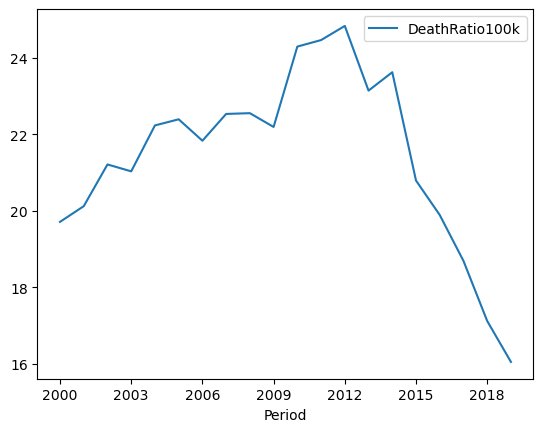

In [25]:
ax = who_df[who_df.LocationId=='BRA'].plot(x='Period', y='DeathRatio100k')
ax.set_xticks(range(2000, 2020, 3))

It shows an increasing pattern up to 2011, then a sharp drop – but the data stops and 2019, and we are more interested in seeing the more recent behavior. I know from [specialized media coverage](https://www.portaldotransito.com.br/noticias/mortes-no-transito-dados-preliminares-de-2022-apontam-leve-queda-em-relacao-a-2021/) that the decreasing trend is slowly reversing.

Let's compare this to the same data published by Brazilian health authorities, which classified all deaths in the country up to 2022. We exported this report from the [Datasus platform](http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sim/cnv/obt10br.def), taking into account all deaths registered under CID-10 classifications between V01 and V89 – that is, all deaths from road traffic. 

However, before going on, we must emphasize that there is caveat in the rate calculation we performed here. 

In the 2022 Census, the population counted was _significantly_ below the previous estimates. If we simply used that, the death rates would artificially fall from 2021 to 2022. As the government hasn't published a retroprojection based on the most up to date Census, we will be using old population projections. 

Moreover, as the projections don't include 2022, we computed the population for that year using a simple linear regression.

The source for this data is the 2000-2021 population estimates made by the Ministry of Health. The file was also exported from the [Datasus portal](http://tabnet.datasus.gov.br/cgi/deftohtm.exe?ibge/cnv/popsvsbr.def).

In [29]:
# Reads and formats the data
br = prepare_death_rate_df(path_deaths="../data/sim/brazil/brazil-all-deaths-1981-2022.csv", 
                           path_pop="../data/pop/brazil-2000-2021-projections-ms-svsa-daent-cgiae.csv",
                           level='brazil')

/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


In [31]:
display(br)
# Saves this for a datawrapper linechart
br.to_csv("../output/datawrapper-line-brazil.csv", index=False)

,Year,TotalDeaths,Location,LocationId,Population,DeathRatio100k
0,2000,28995.00,Brazil,0,173765726.00,16.69
1,2001,30524.00,Brazil,0,176208646.00,17.32
2,2002,32753.00,Brazil,0,178499255.00,18.35
3,2003,33139.00,Brazil,0,180708344.00,18.34
4,2004,35105.00,Brazil,0,182865043.00,19.20
5,2005,35994.00,Brazil,0,184991143.00,19.46
6,2006,36367.00,Brazil,0,187061610.00,19.44
7,2007,37407.00,Brazil,0,189038268.00,19.79
8,2008,38273.00,Brazil,0,191010274.00,20.04
9,2009,37594.00,Brazil,0,192980905.00,19.48


(0.0, 25.0)

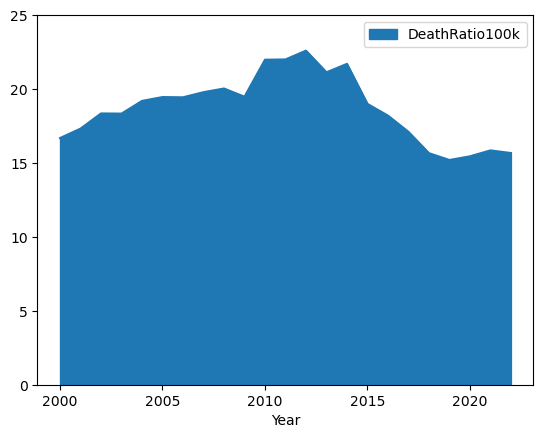

In [32]:
# Plots the rates over time
ax = br.plot(x='Year', y='DeathRatio100k', kind='area')
ax.set_ylim(0, 25)

An increase while in covid-19 years, with a slow drop in 2022. But since this relies on the now unrealiable population data, we should take the numbers with a grain of salt.

What about the absolute number of deaths, then?

(0.0, 48000.0)

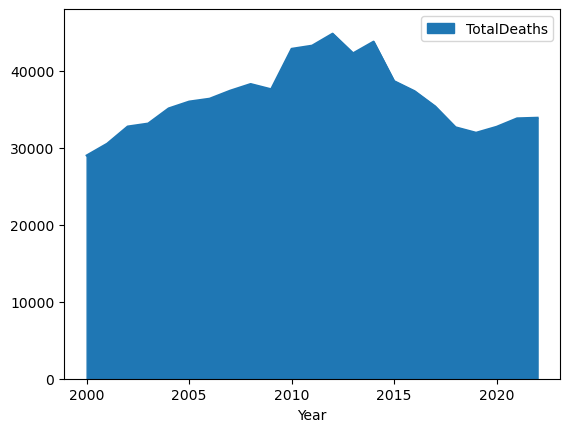

In [33]:
# Plots the rates over time
ax = br.plot(x='Year', y='TotalDeaths', kind='area')
ax.set_ylim(0, 48000)

A steady increase, even if a bit slower in 2022.

It's woth noting that the national data follows the same overall shape as the WHO data, which gives me more confidence in the numbers.

Since now we know that the WHO data is showing roughly the same trend as the Brazilian data, let's move back and compare Brazil to other countries with similar development levels and/or in the same region.

To do so, we will use World Bank income level and regional division data.

In [34]:
# Reads world bank data
wb = format_wb_data("../data/world-bank/classification.xlsx")

In [35]:
# Take a look at it
display(wb)

,Economy,LocationId,WorldBankRegion,IncomeGroup
0,Aruba,ABW,Latin America & Caribbean,High income
1,Afghanistan,AFG,South Asia,Low income
2,Angola,AGO,Sub-Saharan Africa,Lower middle income
3,Albania,ALB,Europe & Central Asia,Upper middle income
4,Andorra,AND,Europe & Central Asia,High income
5,United Arab Emirates,ARE,Middle East & North Africa,High income
6,Argentina,ARG,Latin America & Caribbean,Upper middle income
7,Armenia,ARM,Europe & Central Asia,Upper middle income
8,American Samoa,ASM,East Asia & Pacific,High income
9,Antigua and Barbuda,ATG,Latin America & Caribbean,High income


In [36]:
# Join the World Bank data with the WHO data.
who_df = who_df.merge(wb)

In [37]:
# Shows the merged data, sorted
who_df.sort_values(by=['Period', 'DeathRatio100k'], ascending=False).head(25)

,LocationId,Location,Value,DeathRatio100k,DeathRatio100kLowerBound,DeathRatio100kHigheBound,Period,IsLatestYear,ranking,Economy,WorldBankRegion,IncomeGroup
159,DOM,Dominican Republic,64.6 [39.94 – 97.54],64.60,39.94,97.54,2019,True,1.00,Dominican Republic,Latin America & Caribbean,Upper middle income
146,ZWE,Zimbabwe,41.22 [33.45 – 49.08],41.22,33.45,49.08,2019,True,2.00,Zimbabwe,Sub-Saharan Africa,Lower middle income
140,VEN,Venezuela (Bolivarian Republic of),39.02 [25.9 – 54.93],39.02,25.90,54.93,2019,True,3.00,"Venezuela, RB",Latin America & Caribbean,NaN
139,LBR,Liberia,38.9 [30.52 – 47.67],38.90,30.52,47.67,2019,True,4.00,Liberia,Sub-Saharan Africa,Low income
138,ERI,Eritrea,37.92 [31.06 – 44.99],37.92,31.06,44.99,2019,True,5.00,Eritrea,Sub-Saharan Africa,Low income
137,CAF,Central African Republic,37.72 [29.82 – 45.95],37.72,29.82,45.95,2019,True,6.00,Central African Republic,Sub-Saharan Africa,Low income
136,SSD,South Sudan,36.73 [29.58 – 43.88],36.73,29.58,43.88,2019,True,7.00,South Sudan,Sub-Saharan Africa,Low income
135,SAU,Saudi Arabia,35.94 [31.93 – 39.94],35.94,31.93,39.94,2019,True,8.00,Saudi Arabia,Middle East & North Africa,High income
134,BDI,Burundi,35.46 [28.43 – 42.76],35.46,28.43,42.76,2019,True,9.00,Burundi,Sub-Saharan Africa,Low income
133,COD,Democratic Republic of the Congo,34.86 [27.82 – 42.13],34.86,27.82,42.13,2019,True,10.00,"Congo, Dem. Rep.",Sub-Saharan Africa,Low income


In [38]:
# Takes a look at averages by regional group
who_df[who_df.Period==2019].groupby('WorldBankRegion').DeathRatio100k.median()

WorldBankRegion
East Asia & Pacific          13.27
Europe & Central Asia         6.99
Latin America & Caribbean    15.32
Middle East & North Africa   16.46
North America                 9.00
South Asia                   15.71
Sub-Saharan Africa           28.93
Name: DeathRatio100k, dtype: float64

In [39]:
# Averages by income group
who_df[who_df.Period==2019].groupby('IncomeGroup').DeathRatio100k.median()

IncomeGroup
High income            5.86
Low income            29.54
Lower middle income   19.62
Upper middle income   14.42
Name: DeathRatio100k, dtype: float64

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_dat

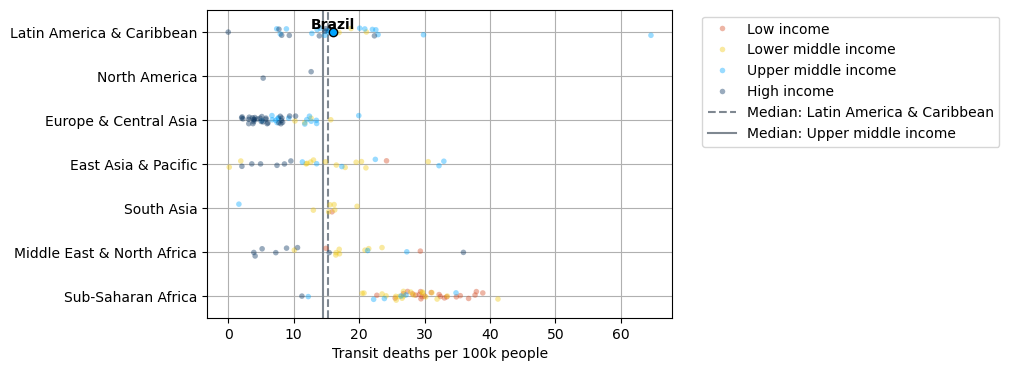

In [40]:
# Plots the merged dataset using the following custom parameters:
palette = {
    'Low income': '#d44820',   # Orange Red
    'Lower middle income': '#f0c80f',   # Yellow
    'Upper middle income': '#00a5ff',   # Light Blue
    'High income': '#002d5a'   # Dark Blue
}

region_order = ['Latin America & Caribbean', 'North America', 
                'Europe & Central Asia', 'East Asia & Pacific', 'South Asia',
                'Middle East & North Africa',  'Sub-Saharan Africa']

income_group_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

create_stripplot(df=who_df,
                        palette=palette, 
                        region_order=region_order, 
                        income_group_order=income_group_order, 
                        title='', 
                        xlabel='Transit deaths per 100k people', ylabel='',
                        region_col='WorldBankRegion', 
                        income_group_col='IncomeGroup',
                        region='Latin America & Caribbean',
                        income_group='Upper middle income', 
                        LocationId='BRA',
                        fname='datawrapper-swarmplot-countries.csv')


We can see that Brazil does slightly worse than the meadian Latin American/Caribbean country, and worse than the median upper middle income country as well.

However, Brazil is a continental country. Within this national number, there are multiple regions with very different rates. Let's take a look at them, individually.

To do so, let's bring in another batch of Datasus statistics: this time, total deaths by _state_ in different years.

In [41]:
states_df = prepare_death_rate_df(path_deaths='../data/sim/states/states-all-deaths-2000-2022.csv',
                              path_pop='../data/pop/states-2000-2021-projections-ms-svsa-daent-cgiae.csv',
                              level='state')

/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


Let's pass the data for the Brazilian states alongside the WHO/WB data to the chart function, so we can see how they compare.

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_dat

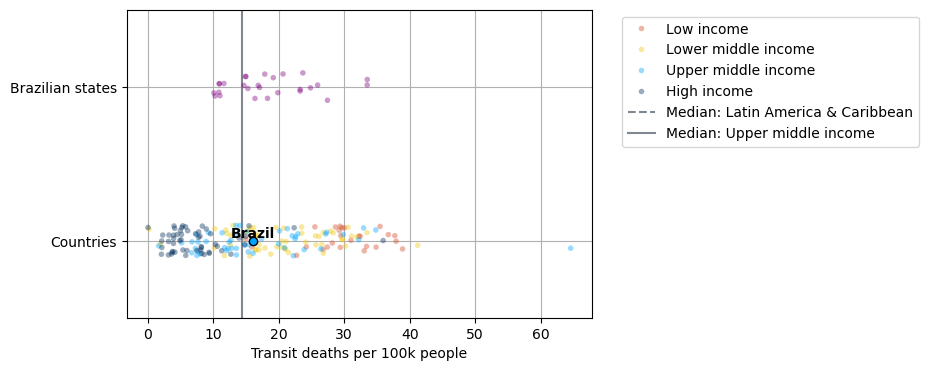

In [42]:
# Plots the merged dataset using the following custom parameters:
palette = {
    'Low income': '#d44820',   # Orange Red
    'Lower middle income': '#f0c80f',   # Yellow
    'Upper middle income': '#00a5ff',   # Light Blue
    'High income': '#002d5a',   # Dark Blue
    '': 'purple'
}

region_order = ['Brazilian states', 'Countries']

income_group_order = ['', 'Low income', 'Lower middle income', 'Upper middle income', 'High income']

joined_df = join_with_states(who_df, states_df)

create_stripplot(df=joined_df,
                    palette=palette, 
                    region_order=region_order, 
                    income_group_order=income_group_order, 
                    title='', 
                    xlabel='Transit deaths per 100k people', ylabel='',
                    region_col='WorldBankRegion', 
                    income_group_col='IncomeGroup',
                    region='Latin America & Caribbean',
                    income_group='Upper middle income', 
                    LocationId='BRA',
                    fname='datawrapper-swarmplot-states.csv')



Some of the Brazilian states are clustered on the bottom, with a death rate similar to some European countries and the best performing nations of Latin America. Some, on the other hand, have rates that are comparable to Sub-Saharan levels.

What are those states with the higher rates?

In [43]:
states_df[states_df.IsLatestYear].sort_values(by='DeathRatio100k', ascending=False)

,Location,LocationId,Year,TotalDeaths,Population,DeathRatio100k,IsLatestYear,IncomeGroup,WorldBankRegion
618,Mato Grosso,51,2022,1220.00,3641235.00,33.51,True,,Brazilian states
600,Tocantins,17,2022,549.00,1639014.00,33.50,True,,Brazilian states
602,Piauí,22,2022,918.00,3347337.00,27.42,True,,Brazilian states
594,Rondônia,11,2022,475.00,1831889.00,25.93,True,,Brazilian states
597,Roraima,14,2022,157.00,632173.00,24.83,True,,Brazilian states
619,Goiás,52,2022,1729.00,7306624.00,23.66,True,,Brazilian states
614,Paraná,41,2022,2718.00,11686444.00,23.26,True,,Brazilian states
617,Mato Grosso do Sul,50,2022,671.00,2886030.00,23.25,True,,Brazilian states
605,Paraíba,25,2022,847.00,4103582.00,20.64,True,,Brazilian states
611,Espírito Santo,32,2022,822.00,4143470.00,19.84,True,,Brazilian states


I know that the leading states are in mostly in the North and Center-west regions. But let's look at them in a Brazilian map as well. To do so, we will use the package `geobr`, which provides easy access to Brazilian shapefiles.

In [44]:
# Adds geometries and other geographical metadata 
states_df = read_geobr(states_df, 'state')

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


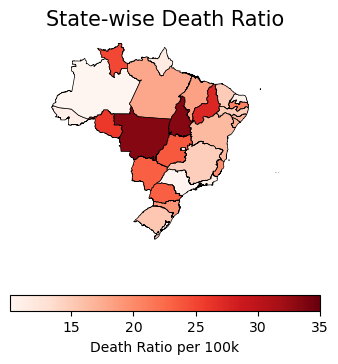

In [45]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(4, 4))  # Adjust figure size
states_df[states_df.IsLatestYear].plot(ax=ax,
         column='DeathRatio100k',
         cmap='Reds',  # Color map
         edgecolor='black',  # Color of the borders
         linewidth=0.5,
         legend=True,
         vmax=35,
         legend_kwds={'label': "Death Ratio per 100k",
                      'orientation': "horizontal"})  # Legend customization

# Additional plot settings
ax.set_title('State-wise Death Ratio', fontsize=15)  # Title of the plot
ax.axis('off')  # Turn off axis

plt.show()

Let's take a look at that in a strip plot as well.

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


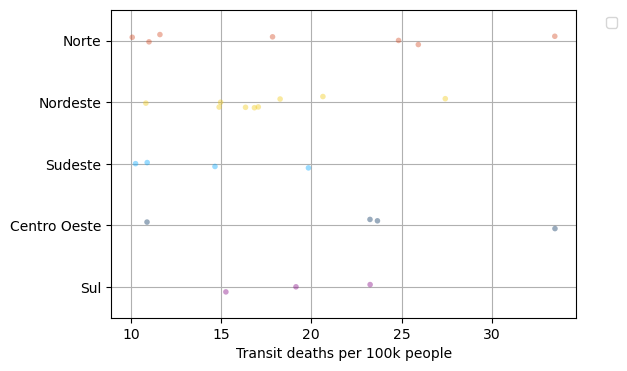

In [46]:
# A strip plot with the death rates by state, grouped by region
# Plots the merged dataset using the following custom parameters:
palette = {
    'Norte': '#d44820',   # Orange Red
    'Nordeste': '#f0c80f',   # Yellow
    'Sudeste': '#00a5ff',   # Light Blue
    'Centro Oeste': '#002d5a',   # Dark Blue
    'Sul': 'purple'
}

region_order = ['Norte', 'Nordeste', 'Sudeste', 'Centro Oeste', 'Sul']

income_group_order = ['Norte', 'Nordeste', 'Sudeste', 'Centro Oeste', 'Sul']

create_stripplot(df=states_df,
                        palette=palette, 
                        region_order=region_order, 
                        income_group_order=income_group_order, 
                        title='', 
                        xlabel='Transit deaths per 100k people', ylabel='',
                        region_col='RegionName', 
                        income_group_col='RegionName',
                        region=None,
                        income_group=None, 
                        LocationId=None)


There is a very high death ratio in the **Center-west** of the country, alongside some North and Northeast states and one specific state in the South, Paraná.

I also know, however, that those states were already among those with the highest death rates years ago. Let's plot the data in line charts to see the trend over time.

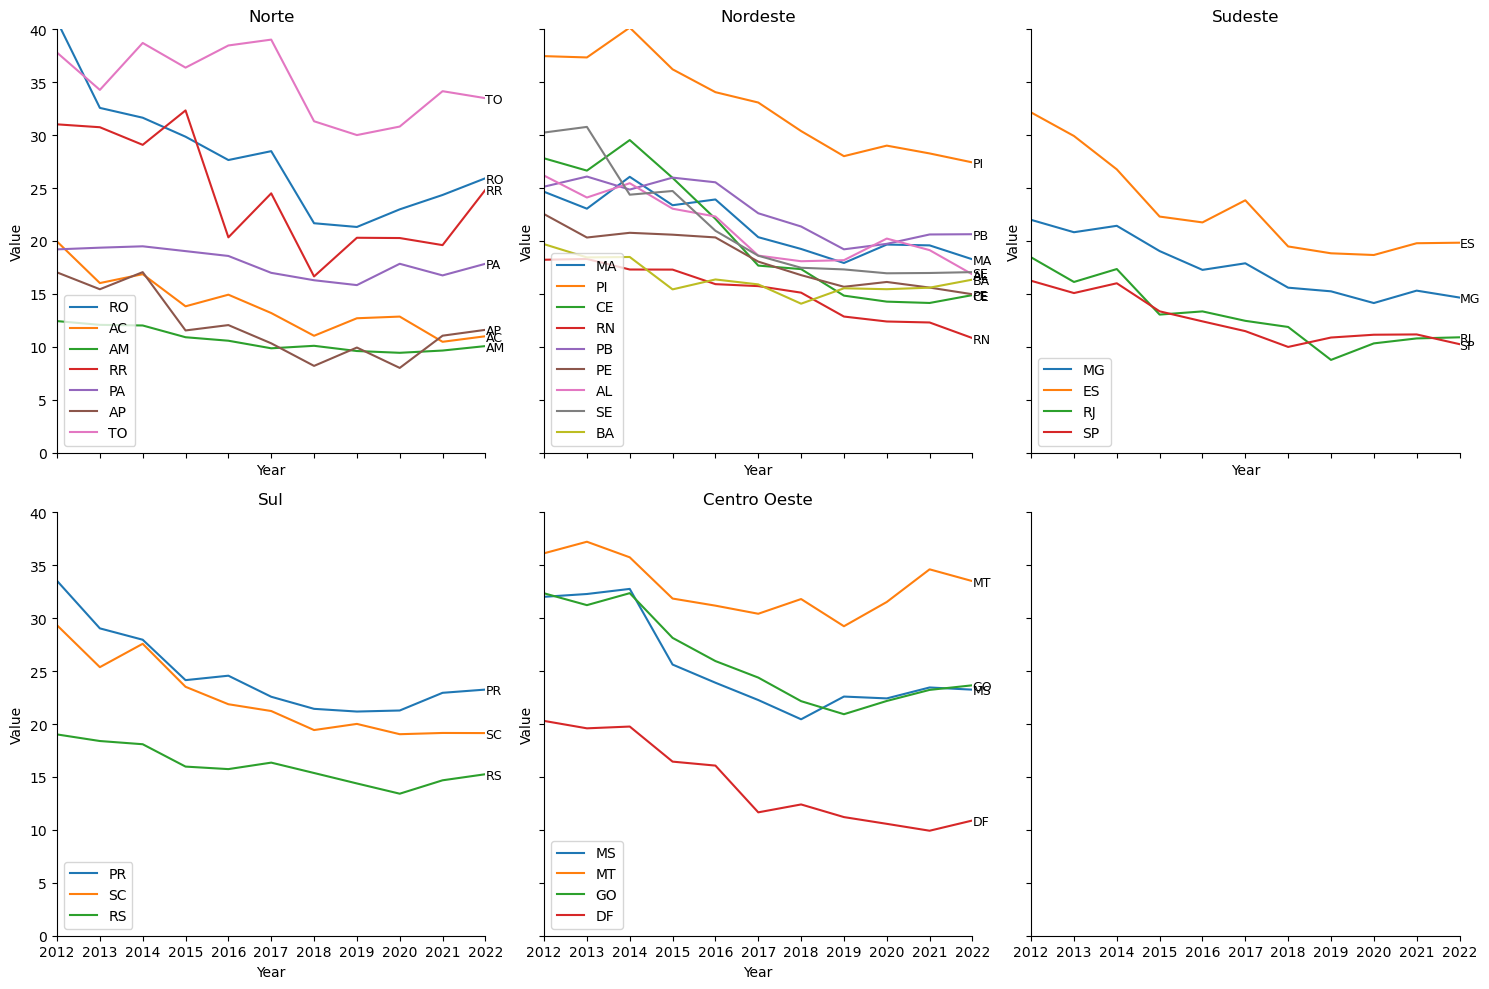

In [47]:
plot_region_state_time_evolution(states_df, 'RegionName', 'StateAbbrev', 'Year', 'DeathRatio100k', "2012", "2022")

Looking at the last 10 years, the general trend still seems to be downward, but the North and Center-West still stand out: while other states are still falling or flat, they saw sharp rises.

A simpler way to see this is to look at percentage variations. How much has the death rate grown in each state in the last five years – our interval of interest?

First, let' s take a look at the variation in total cases.

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_dat

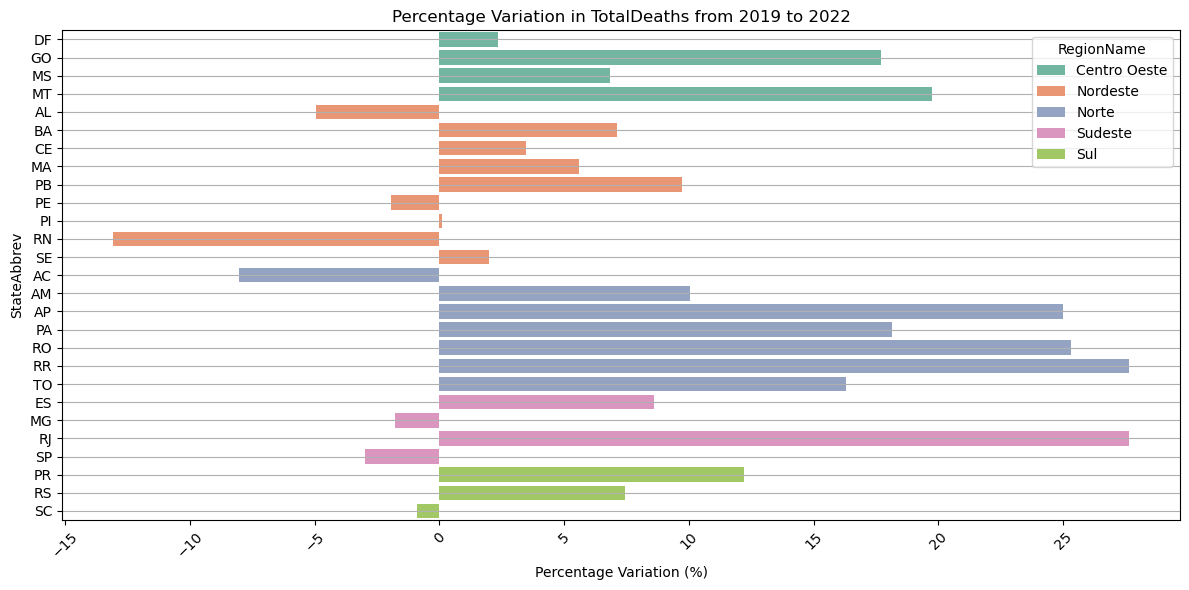

In [48]:
plot_variation(data=states_df, group_column='StateAbbrev',
               value_column='TotalDeaths', region_column='RegionName',
               start_year='2019', end_year='2022', fname="../output/datawrapper-bars-region-state.csv")

And then at the ratio variation, just to check if the population hides something.

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_dat

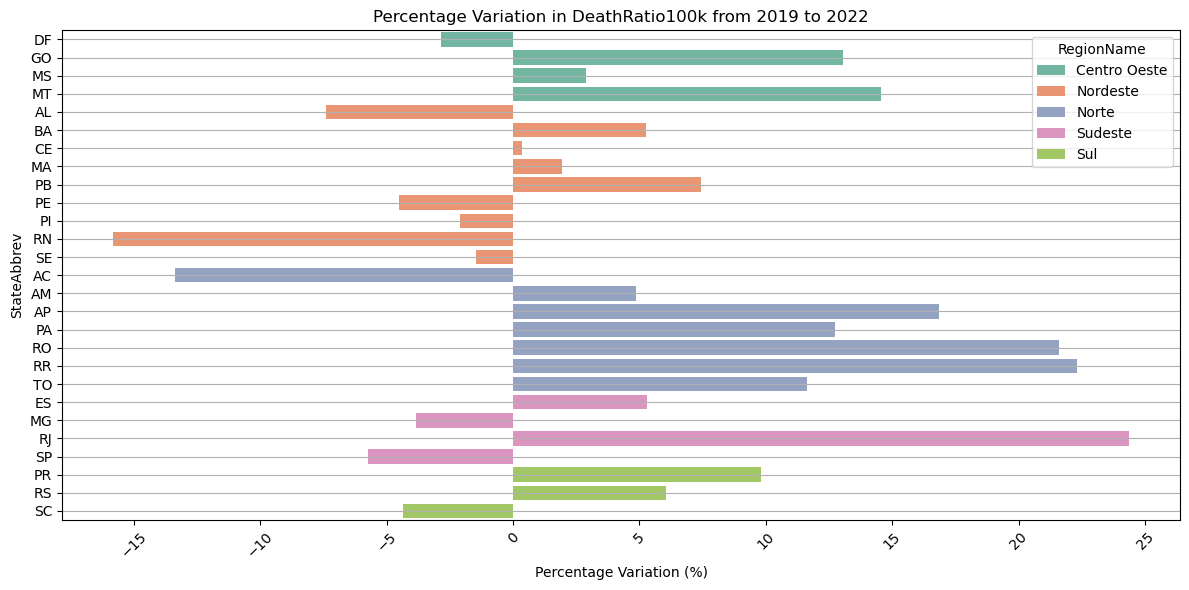

In [49]:
plot_variation(data=states_df, group_column='StateAbbrev',
               value_column='DeathRatio100k', region_column='RegionName',
               start_year='2019', end_year='2022')

We see that, while most of the states in the North/Center-West had a death increase, most of the staetes in the Northeast saw a decrease in deaths. Those were the regions with the highest death rates in the previous decade. The remaining states with significant rises (PR, SC, RJ, ES) are also interesting, but this increase is coming from a way lower baseline.

Let's try a different view: a range plot with death ratios per state and their variation. This is easier done in datawrapper, so let's create a pivot table and export it to work there. (This became an arrow plot in the Portuguese version of the story).

In [50]:
states_df[states_df.Year.isin(['2019', '2022'])].pivot(index=['StateAbbrev', 'RegionName'], 
                                                       values='DeathRatio100k', 
                                                       columns='Year')\
                                                .reset_index().sort_values(by=['RegionName', 'StateAbbrev'])\
                                                .to_csv("../output/datawrapper-rangeplot-states.csv", index=False)

Let's take a look at aggregate regional values to see how the picture looks like at this level, instead of simply by state.

In [51]:
df_regions = prepare_death_rate_df(path_deaths='../data/sim/regions/regions-all-deaths-2000-2022.csv',
                              path_pop='../data/pop/regions-2000-2021-projections-ms-svsa-daent-cgiae.csv',
                              level='region')

/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


In [52]:
display(df_regions)

,Location,LocationId,Year,TotalDeaths,Population,DeathRatio100k
0,Região Norte,1,2000,1892.00,13249163.00,14.28
1,Região Nordeste,2,2000,6518.00,48989940.00,13.30
2,Região Sudeste,3,2000,11656.00,73962109.00,15.76
3,Região Sul,4,2000,5843.00,25631396.00,22.80
4,Região Centro-Oeste,5,2000,3086.00,11933118.00,25.86
5,Região Norte,1,2001,1930.00,13566049.00,14.23
6,Região Nordeste,2,2001,6578.00,49616085.00,13.26
7,Região Sudeste,3,2001,13061.00,74920766.00,17.43
8,Região Sul,4,2001,5830.00,25919485.00,22.49
9,Região Centro-Oeste,5,2001,3125.00,12186261.00,25.64


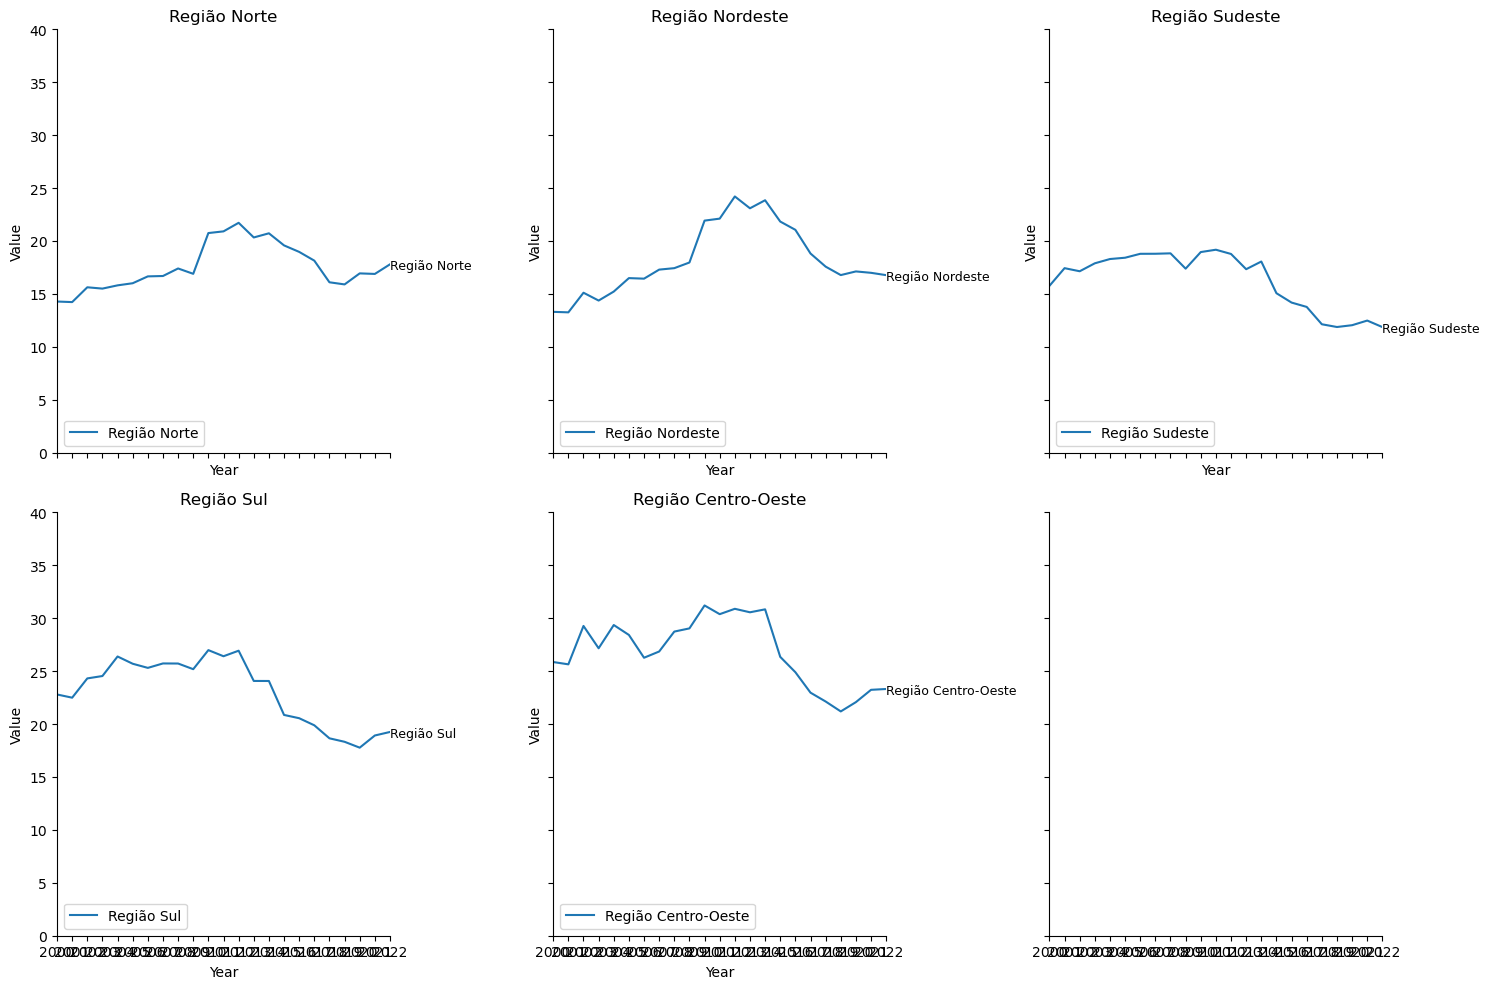

In [53]:
# Line charts, ratio
plot_region_time_evolution(df_regions, 'Location', 'Year', 'DeathRatio100k', '2000', '2022')

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_dat

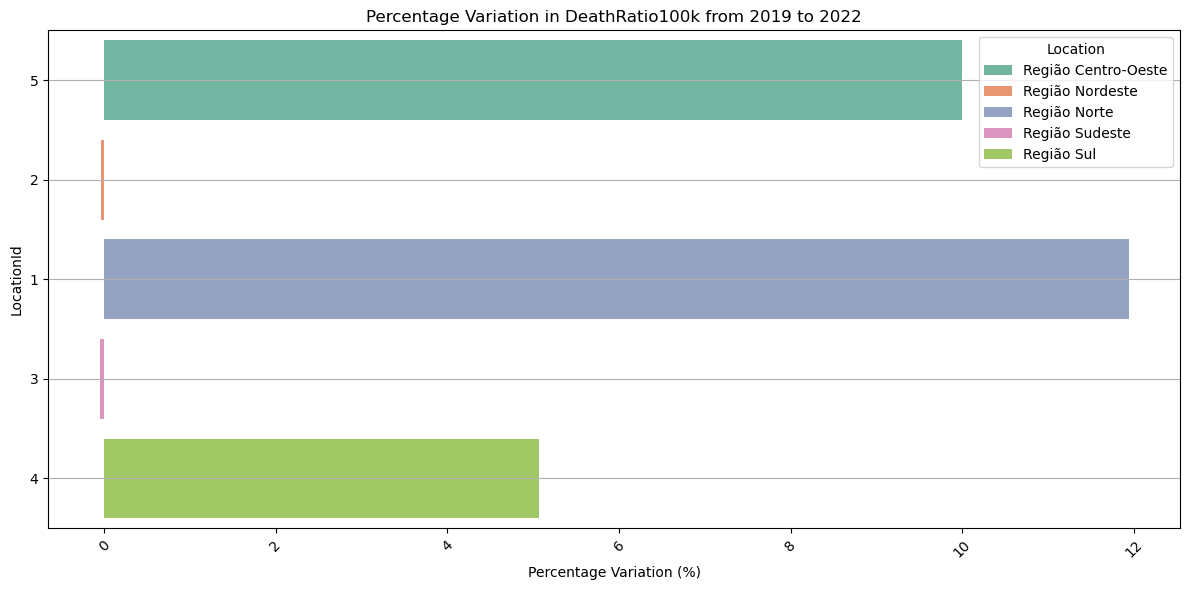

In [54]:
# Bar chart, ratio
plot_variation(data=df_regions, group_column='LocationId',
               value_column='DeathRatio100k', region_column='Location',
               start_year='2019', end_year='2022')

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_dat

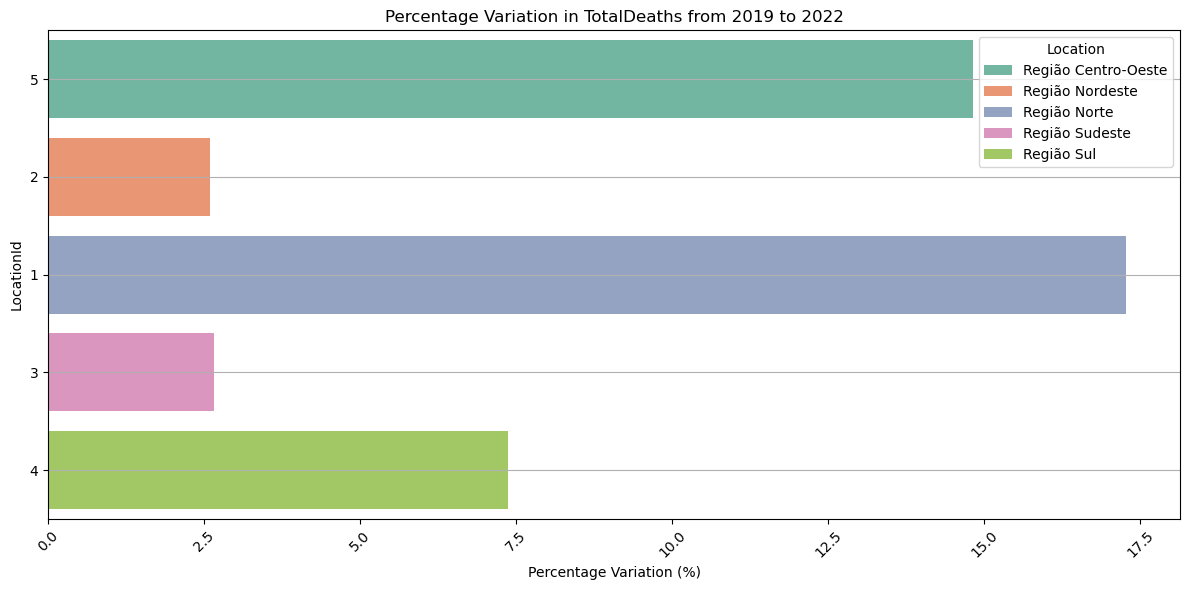

In [55]:
# Bar chart, total deaths
plot_variation(data=df_regions, group_column='LocationId',
               value_column='TotalDeaths', region_column='Location',
               start_year='2019', end_year='2022')

In aggregate, the North and Center-West regions had by far the highest increase, as we could see.

But what is driving those deaths?

The research I've seen says that the past increases were mostly driven by an increase in motorcycle accidents. Let's take a look at a subset of the data, also exported from the Datasus platform, and see how they compare. To do so, we will use groupings of the CID-10 injury classifications to have categories according to the kind of vehicle involved in the accident.

The following analysis are based on these CID10 category codes:

- Pedestrian death, all kinds of collision: V01 – V09
- Cyclist death, all kinds of collision: V10 – V10
- Motorcyclist death, all kinds of collision: V20 - V29
- Tricyclist death, all kinds of collision: V30 – V39
- Car driver death, all kinds of collision: V40 – V49
- Pikcup driver death, all kinds of collision: V50 – 59
- Heavy transportation vehicle driver death, all kinds of collision: V60 – V69
- Bus driver death, all kinds of collision: V70 – V79
- Other vehicle driver deaths, all kinds of collision: V80 – V89.


And, aditionally:
- All kinds of vehicle driver death, in collision with heavy vehicle or bus: V04, V14, V24, V34, V44, V54, V64, V74

Let's read the data for each kind of transportation death and combine them into a single dataframe, so we can see how they evolved over time.

In [56]:
br_vehicles = get_rates_per_vehicle('brazil')

../data/sim/brazil/brazil-all-deaths-2000-2022.csv
../data/sim/brazil/brazil-bicycle-deaths-2000-2022.csv
../data/sim/brazil/brazil-bus-deaths-2000-2022.csv
../data/sim/brazil/brazil-car-deaths-2000-2022.csv
../data/sim/brazil/brazil-heavy-vehicle-deaths-2000-2022.csv
../data/sim/brazil/brazil-motorcycle-deaths-2000-2022.csv
../data/sim/brazil/brazil-pedestrian-deaths-2000-2022.csv
../data/sim/brazil/brazil-pickup-deaths-2000-2022.csv
../data/sim/brazil/brazil-tricycle-deaths-2000-2022.csv
../data/sim/brazil/brazil-other-vehicle-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()
/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress

Now, for each state, let's compute how the death ratios by vehicle occupant rose.

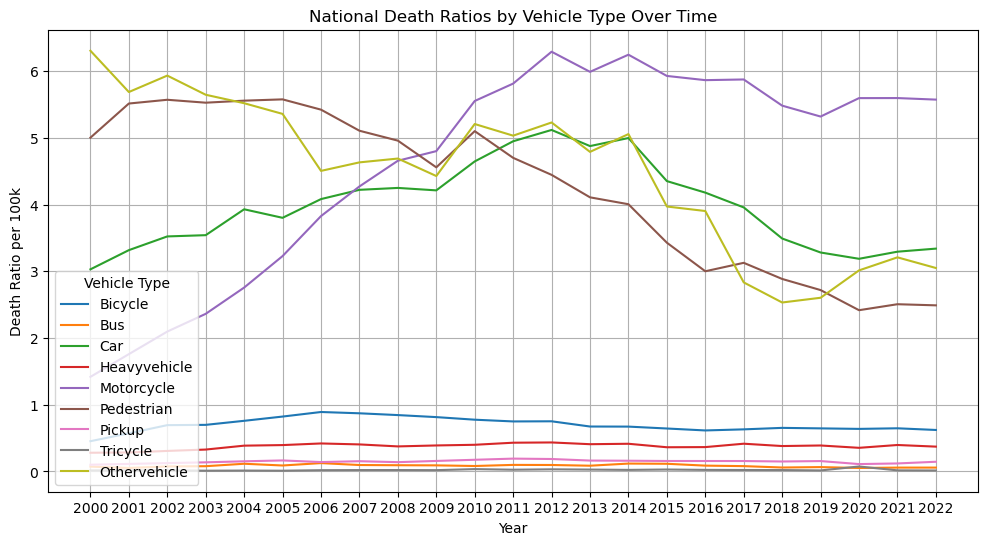

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))

vehicle_types = ['Bicycle', 'Bus', 'Car', 'Heavyvehicle', 'Motorcycle', 'Pedestrian', 'Pickup', 'Tricycle', 'Othervehicle']

# Plot each vehicle type's death ratio over time
for vehicle_type in vehicle_types:
    vehicle_column = f'{vehicle_type}DeathRatio100k'
    if vehicle_column in br_vehicles.columns:
        ax.plot(br_vehicles['Year'], br_vehicles[vehicle_column], label=vehicle_type)

ax.set_title('National Death Ratios by Vehicle Type Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Death Ratio per 100k')
ax.legend(title='Vehicle Type', loc='lower left')
ax.grid(True)

plt.show()

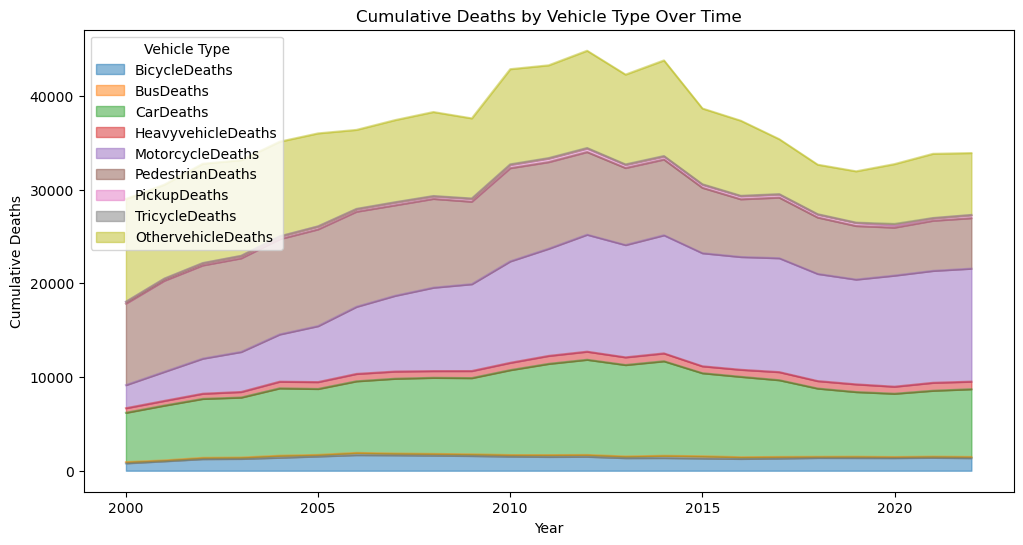

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))

# Select columns for area chart
area_chart_columns = [f'{vehicle}Deaths' for vehicle in vehicle_types if f'{vehicle}Deaths' in br_vehicles.columns]

# Plot stacked area chart
br_vehicles.plot.area(x='Year', y=area_chart_columns, ax=ax, stacked=True, alpha=0.5)

ax.set_title('Cumulative Deaths by Vehicle Type Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Deaths')
ax.legend(title='Vehicle Type')

plt.show()


The modal with the largest increase since 2019 seems to be OtherVehicles, which is mostly made of 'unknown' vehicles – that is, bad data entry.

Let's quickly see how this division of deaths by kind of vehicle varies by state. Let's see this in a simple slope chart instead of lines, for simplicity sake, focusing in the period between 2019 and 2022.

In [59]:
states_df = read_geobr(get_rates_per_vehicle('states'), kind='state')

../data/sim/states/states-all-deaths-2000-2022.csv
../data/sim/states/states-bicycle-deaths-2000-2022.csv
../data/sim/states/states-bus-deaths-2000-2022.csv
../data/sim/states/states-car-deaths-2000-2022.csv
../data/sim/states/states-heavy-vehicle-deaths-2000-2022.csv
../data/sim/states/states-motorcycle-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()
/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress

../data/sim/states/states-pedestrian-deaths-2000-2022.csv
../data/sim/states/states-pickup-deaths-2000-2022.csv
../data/sim/states/states-tricycle-deaths-2000-2022.csv
../data/sim/states/states-other-vehicle-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()
/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress

Also for simplcity, we will be focusing on the following states, which had total death increases near 10%+: Goiás, Mato Grosso, Amapá, Rondônia, Roraima, Tocantins, Pará, Paraná and Rio de Janeiro.

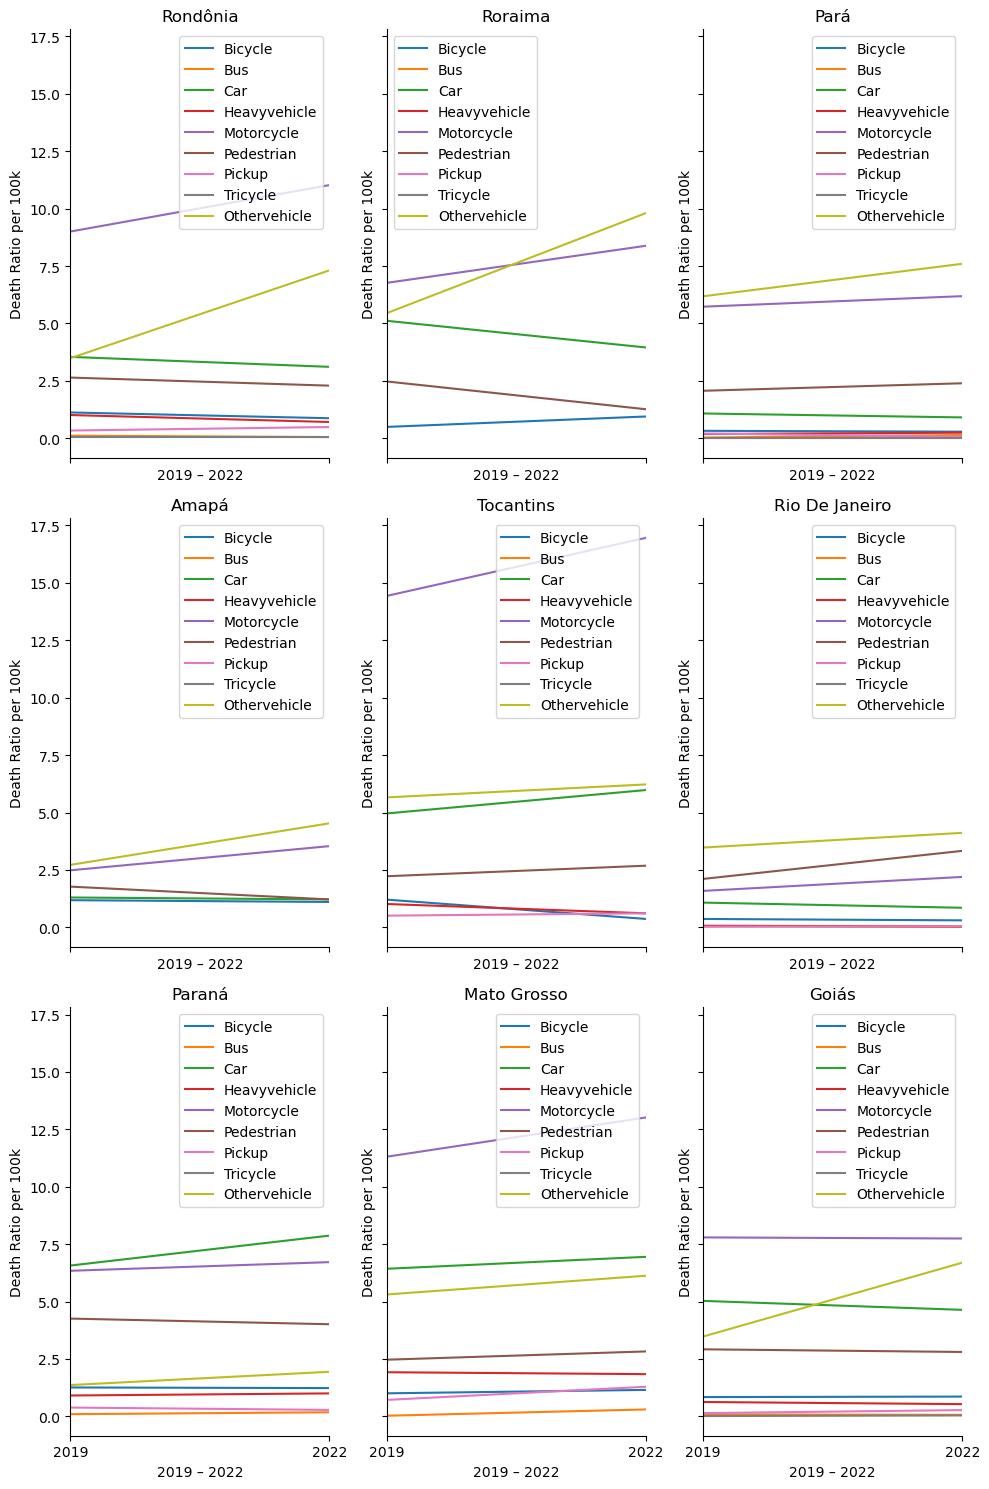

In [60]:
vehicle_types = ['Bicycle', 'Bus', 'Car', 'Heavyvehicle', 'Motorcycle', 'Pedestrian', 'Pickup', 'Tricycle', 'Othervehicle']
#vehicle_types = ['Othervehicle']
plot_state_vehicle_death_time_evolution(
    states_df[states_df.StateAbbrev.isin(
        ['GO', 'MT', 'AP', 'RO', 'RR', 'TO', 'PA', 'PR', 'RJ'])], 
                'StateName', 'Year', vehicle_types)

We can see that motorcycles and other/unknown vehicles are the main drivers. However, two execptions stand out: car deaths in Paraná and pedestrian deaths in Rio de Janeiro.

What can we learn if we dig into the microrregion level?

In [61]:
micro_df = prepare_death_rate_df(path_deaths='../data/sim/micro/micro-all-deaths-2000-2022.csv',
                              path_pop='../data/pop/micro-2000-2021-projections-ms-svsa-daent-cgiae.csv',
                              level='state')

/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


In [62]:
# Adds geometry and state data
micro_df = read_geobr(micro_df, 'micro')

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [63]:
# Keeps only the states we have interest in
#micro_df = micro_df[micro_df.StateAbbrev.isin(['RO', 'RR', 'AP', 'PA', 'TO', 'MT', 'GO', 'MS', 'PR', 'RJ'])]

First, we want to discover which cities had the highest increase in deaths from 2019 to 2022. To do, we will have to pivot the data.

In [64]:
#  Keeps only the years of interest
micro_df = micro_df[micro_df.Year.isin(['2019', '2020', '2021', '2022'])]

In [65]:
# Pivots it
micro_pivot = micro_df.pivot(index=['MicroId', 'MicroName', 'StateAbbrev'], columns='Year', values='TotalDeaths').reset_index()

# Compute the percentage variation
micro_pivot['PercentageVariation'] = (micro_pivot['2022'] - micro_pivot['2019']) / (micro_pivot['2019']) * 100
micro_pivot['AbsolutVariation'] = (micro_pivot['2022'] - micro_pivot['2019'])

# Sort values by region and then by group
micro_pivot = micro_pivot.sort_values(by='PercentageVariation', ascending=False)

# Keeps the geometry information so we can make maps
micro_pivot = micro_df[['geometry', 'MicroId']].drop_duplicates().merge(micro_pivot)

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/geopandas/array.py:125: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [66]:
# This bit is necessary for exporting the files to datawrapper in order to make maps
micro_pivot['latitude'] = micro_pivot.geometry.centroid.y
micro_pivot['longitude'] = micro_pivot.geometry.centroid.x
micro_pivot['rising'] = micro_pivot.AbsolutVariation > 0
micro_pivot['abs_change'] = micro_pivot.AbsolutVariation.abs()
micro_pivot['abs_pct_change'] = micro_pivot.PercentageVariation.abs()


micro_pivot[['MicroId', 'latitude', 'longitude', 'AbsolutVariation', 'abs_change', 
             'PercentageVariation', 'abs_pct_change', 'rising']].to_csv("../output/datawrapper-micro-pivot.csv", index=False)


micro_pivot[micro_pivot.AbsolutVariation > 0][['MicroId', 'latitude', 'longitude', 'AbsolutVariation', 'abs_change', 
             'PercentageVariation', 'abs_pct_change', 'rising']].to_csv("../output/datawrapper-rising-micro-pivot.csv", index=False)

micro_pivot[micro_pivot.AbsolutVariation <= 0][['MicroId', 'latitude', 'longitude', 'AbsolutVariation', 'abs_change', 
             'PercentageVariation', 'abs_pct_change', 'rising']].to_csv("../output/datawrapper-not-rising-micro-pivot.csv", index=False)

/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/geopandas/array.py:546: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/geopandas/geoseries.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/geopandas/array.py:546: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
/Users/menegatschuinskir/miniforge3/envs/geo/lib/python3.11/site-packages/geopandas/geoseries.py:128: ShapelyDeprecationWarning: The array interfac

In [67]:
# Adds population back again
micro_pivot = micro_pivot.merge(micro_df[micro_df.Year=='2022'][['MicroId', 'Population']])\
    .rename(columns={'Population':'Population_2022'})

In [68]:
micro_pivot.sort_values(by='PercentageVariation', ascending=False)

,geometry,MicroId,MicroName,StateAbbrev,2019,2020,2021,2022,PercentageVariation,AbsolutVariation,latitude,longitude,rising,abs_change,abs_pct_change,Population_2022
115,"MULTIPOLYGON (((-38.60838 -6.53193, -38.61217 ...",23028,Lavras Da Mangabeira,CE,3.00,10.00,8.00,14.00,366.67,11.00,-6.75,-38.89,True,11.00,366.67,58121.00
9,"MULTIPOLYGON (((-69.44261 -8.36795, -68.64719 ...",12003,Sena Madureira,AC,2.00,7.00,3.00,8.00,300.00,6.00,-9.61,-69.66,True,6.00,300.00,66026.00
552,"MULTIPOLYGON (((-50.03682 -16.04344, -50.03720...",52009,Anicuns,GO,16.00,31.00,36.00,50.00,212.50,34.00,-16.44,-50.19,True,34.00,212.50,119859.00
517,"MULTIPOLYGON (((-55.12095 -14.20394, -55.11317...",51016,Rosário Oeste,MT,6.00,9.00,6.00,18.00,200.00,12.00,-14.87,-56.04,True,12.00,200.00,30610.00
96,"MULTIPOLYGON (((-44.32512 -7.11181, -44.31590 ...",22007,Alto Parnaíba Piauiense,PI,10.00,26.00,25.00,29.00,190.00,19.00,-8.29,-45.10,True,19.00,190.00,48683.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,"MULTIPOLYGON (((-65.37114 -2.65917, -65.37684 ...",13004,Juruá,AM,8.00,9.00,9.00,3.00,-62.50,-5.00,-5.98,-68.71,False,5.00,62.50,160214.00
268,"MULTIPOLYGON (((-41.22823 -15.73668, -41.21167...",31013,Pedra Azul,MG,22.00,18.00,17.00,8.00,-63.64,-14.00,-16.17,-41.44,False,14.00,63.64,81749.00
51,"MULTIPOLYGON (((-51.17970 4.00008, -51.17739 3...",16001,Oiapoque,AP,9.00,5.00,5.00,3.00,-66.67,-6.00,2.83,-51.71,False,6.00,66.67,41427.00
8,"MULTIPOLYGON (((-70.05145 -7.84816, -69.44432 ...",12002,Tarauacá,AC,11.00,9.00,9.00,2.00,-81.82,-9.00,-8.70,-71.12,False,9.00,81.82,89331.00


As expected, some of the regions with the highest percentage increase had almost no incidents in 2019, and just a few more in 2022. Let's apply a new filter to keep only those which had a relevant number of incidents.

In [69]:
micro_pivot[micro_pivot['2019'] > 10].sort_values(by='PercentageVariation', ascending=False)

,geometry,MicroId,MicroName,StateAbbrev,2019,2020,2021,2022,PercentageVariation,AbsolutVariation,latitude,longitude,rising,abs_change,abs_pct_change,Population_2022
552,"MULTIPOLYGON (((-50.03682 -16.04344, -50.03720...",52009,Anicuns,GO,16.00,31.00,36.00,50.00,212.50,34.00,-16.44,-50.19,True,34.00,212.50,119859.00
157,"MULTIPOLYGON (((-37.28372 -6.69391, -37.29017 ...",25004,Patos,PB,11.00,32.00,29.00,24.00,118.18,13.00,-7.01,-37.32,True,13.00,118.18,137102.00
338,"MULTIPOLYGON (((-42.13439 -22.54212, -42.13122...",33010,Lagos,RJ,44.00,71.00,73.00,93.00,111.36,49.00,-22.79,-42.23,True,49.00,111.36,690255.00
87,"MULTIPOLYGON (((-40.67502 -6.67810, -40.64914 ...",22014,Pio Ix,PI,13.00,20.00,12.00,27.00,107.69,14.00,-6.90,-40.88,True,14.00,107.69,62264.00
419,"MULTIPOLYGON (((-51.81888 -24.44962, -51.81813...",41028,Pitanga,PR,13.00,24.00,31.00,26.00,100.00,13.00,-24.81,-51.98,True,13.00,100.00,65901.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,"MULTIPOLYGON (((-43.58355 -22.05582, -43.58469...",33012,Barra Do Piraí,RJ,36.00,15.00,11.00,17.00,-52.78,-19.00,-22.27,-43.81,False,19.00,52.78,189738.00
15,"MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...",13001,Rio Negro,AM,13.00,7.00,8.00,6.00,-53.85,-7.00,-0.34,-65.13,False,7.00,53.85,124365.00
133,"MULTIPOLYGON (((-37.64858 -5.94131, -37.59310 ...",24007,Umarizal,RN,19.00,19.00,16.00,8.00,-57.89,-11.00,-6.11,-37.80,False,11.00,57.89,67079.00
268,"MULTIPOLYGON (((-41.22823 -15.73668, -41.21167...",31013,Pedra Azul,MG,22.00,18.00,17.00,8.00,-63.64,-14.00,-16.17,-41.44,False,14.00,63.64,81749.00


From those, let's pick some regions that are particulary interesting, for possible on the ground reporting:

- Anciuns, GO, 52009 (highest rate among regions with more than 10 deaths in 2019)
- Conceição do Araguaia, PA, 15022 (in the South of Pará, an agricultural region. Second highest increase)
- Cornélio Procópio, PR, 41015 (example of growth in the South)
- Baía da Ilha Grande, 33013, RJ (example of growth in Rio de Janeiro)
- Sinop, MT, 51007 (symbol of agricultural development in Brazil)

I want to know which kind of vehicle was involved in the deaths of each of those regions. 

In [70]:
selected_df = read_geobr(get_rates_per_vehicle('micro'), kind='micro')

../data/sim/micro/micro-all-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-bicycle-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-bus-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-car-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-heavy-vehicle-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-motorcycle-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-pedestrian-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-pickup-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-tricycle-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


../data/sim/micro/micro-other-vehicle-deaths-2000-2022.csv


/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/325135228.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predictions = df.groupby(['Location', 'LocationId']).apply(regress_and_predict).round()


In [71]:
selected_df = selected_df[selected_df.MicroId.isin([
    '52009', '15022', '41015', '33013', '51007', '41021' # last is my region
])]

In [72]:
# In case there were no deaths of a particular type
selected_df = selected_df.fillna(0)

/var/folders/yl/bd_xy2c53495c2z2g0w0yrzdtddnbq/T/ipykernel_84103/639877269.py:2: DeprecationWarning: ExtensionArray.fillna added a 'copy' keyword in pandas 2.1.0. In a future version, ExtensionArray subclasses will need to implement this keyword or an exception will be raised. In the interim, the keyword is ignored by GeometryArray.
  selected_df = selected_df.fillna(0)


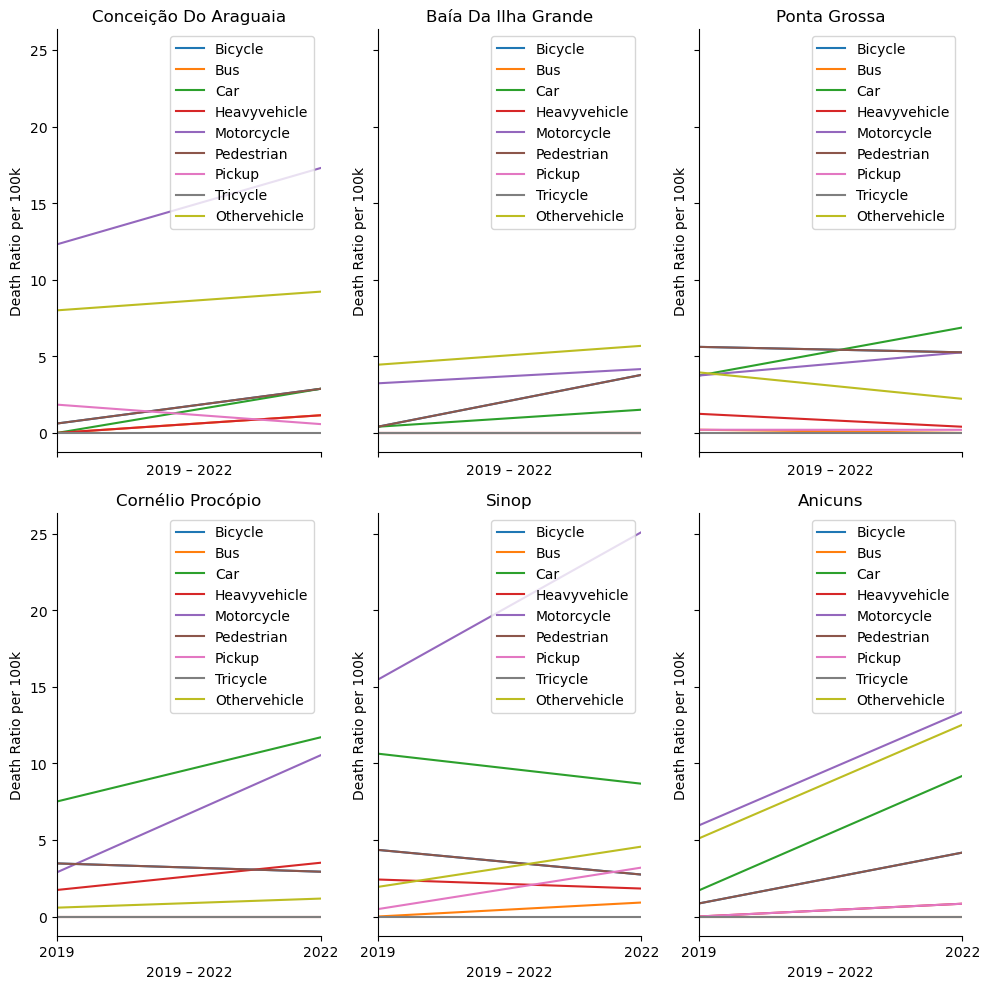

In [73]:
vehicle_types = ['Bicycle', 'Bus', 'Car', 'Heavyvehicle', 'Motorcycle', 'Pedestrian', 'Pickup', 'Tricycle', 'Othervehicle']
plot_state_vehicle_death_time_evolution(selected_df, 'MicroName', 'Year', vehicle_types)